Kelani Ganga Flood Risk Prediction System Starting...

Cleaned data saved.

Training on 5020 samples, Testing on 1256 samples

Training models...
  → Random Forest
  → XGBoost
  → Linear Regression
  → SVR

                  MODEL PERFORMANCE COMPARISON
            Model  Accuracy     R2    MSE  Composite Score
          XGBoost    0.9833 0.9985 0.0225           0.9868
    Random Forest    0.9817 0.9985 0.0229           0.9859
              SVR    0.9761 0.9975 0.0381           0.9800
Linear Regression    0.9403 0.9673 0.5034           0.8934

BEST MODEL SELECTED → XGBoost
Accuracy: 98.3% | Composite Score: 0.9868



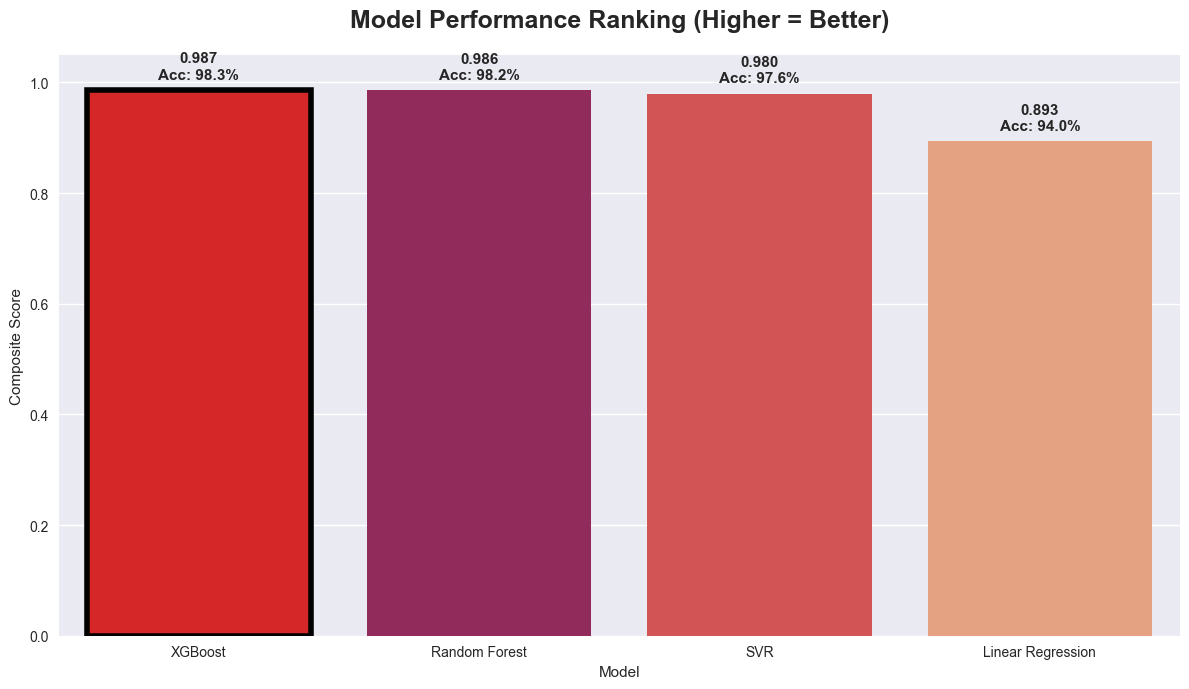

Generating 7-day flood forecast with community messages...

           KELANI GANGA 7-DAY FLOOD FORECAST WITH COMMUNITY MESSAGES


,Date,Station,Predicted Level (m),Status,Message (English),පණිවිඩය (සිංහල)
0,2025-12-31,Nagalagam Street,0.238,Normal,All clear! River is safe. Have a peaceful and productive day!,සියල්ල ආරක්ෂිතයි! ගඟ සාමාන්‍ය තත්ත්වයේ පවතී. සාමකාමී දිනයක් ගත කරන්න!
1,2026-01-01,Nagalagam Street,0.169,Normal,All clear! River is safe. Have a peaceful and productive day!,සියල්ල ආරක්ෂිතයි! ගඟ සාමාන්‍ය තත්ත්වයේ පවතී. සාමකාමී දිනයක් ගත කරන්න!
2,2026-01-02,Nagalagam Street,0.148,Normal,All clear! River is safe. Have a peaceful and productive day!,සියල්ල ආරක්ෂිතයි! ගඟ සාමාන්‍ය තත්ත්වයේ පවතී. සාමකාමී දිනයක් ගත කරන්න!
3,2026-01-03,Nagalagam Street,0.167,Normal,All clear! River is safe. Have a peaceful and productive day!,සියල්ල ආරක්ෂිතයි! ගඟ සාමාන්‍ය තත්ත්වයේ පවතී. සාමකාමී දිනයක් ගත කරන්න!
4,2026-01-04,Nagalagam Street,0.167,Normal,All clear! River is safe. Have a peaceful and productive day!,සියල්ල ආරක්ෂිතයි! ගඟ සාමාන්‍ය තත්ත්වයේ පවතී. සාමකාමී දිනයක් ගත කරන්න!
5,2026-01-05,Nagalagam Street,0.171,Normal,All clear! River is safe. Have a peaceful and productive day!,සියල්ල ආරක්ෂිතයි! ගඟ සාමාන්‍ය තත්ත්වයේ පවතී. සාමකාමී දිනයක් ගත කරන්න!
6,2026-01-06,Nagalagam Street,0.180,Normal,All clear! River is safe. Have a peaceful and productive day!,සියල්ල ආරක්ෂිතයි! ගඟ සාමාන්‍ය තත්ත්වයේ පවතී. සාමකාමී දිනයක් ගත කරන්න!
7,2025-12-31,Hanwella,1.113,Normal,All clear! River is safe. Have a peaceful and productive day!,සියල්ල ආරක්ෂිතයි! ගඟ සාමාන්‍ය තත්ත්වයේ පවතී. සාමකාමී දිනයක් ගත කරන්න!
8,2026-01-01,Hanwella,1.107,Normal,All clear! River is safe. Have a peaceful and productive day!,සියල්ල ආරක්ෂිතයි! ගඟ සාමාන්‍ය තත්ත්වයේ පවතී. සාමකාමී දිනයක් ගත කරන්න!
9,2026-01-02,Hanwella,1.097,Normal,All clear! River is safe. Have a peaceful and productive day!,සියල්ල ආරක්ෂිතයි! ගඟ සාමාන්‍ය තත්ත්වයේ පවතී. සාමකාමී දිනයක් ගත කරන්න!



7-day forecast saved → river_flood/7_Day_Flood_Forecast_With_Messages.csv
All station files saved in river_flood/

SYSTEM COMPLETE! Ready to share with communities and authorities.


In [19]:
# ========================================================
# KELANI GANGA FLOOD PREDICTION
# 7-Day Forecast with Motivational Messages in English & Sinhala
# ========================================================

import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# -------------------------------
# 1. SETUP
# -------------------------------
os.makedirs("river_flood", exist_ok=True)
plt.style.use('seaborn-v0_8')
sns.set_palette("deep")

print("Kelani Ganga Flood Risk Prediction System Starting...\n")

# -------------------------------
# 2. LOAD & CLEAN DATA
# -------------------------------
df = pd.read_csv("C:/Users/Lengi/Desktop/flood_kelani/ENV_RISK_BACKEND/River_Water_data.csv")

# Clean station names
df['Station'] = df['Station'].str.strip()
df['Station'] = df['Station'].replace({
    'Kithulgala': 'Kitulgala',
    'Kilbulgala': 'Kitulgala',
    'Nagalagam Street': 'Nagalagam Street'
}, regex=True)

df['Remarks'] = df['Remarks'].replace({'Major Plud': 'Major Flood', '': 'Normal'}).fillna('Normal')

# Combine date & time
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                               format='%d-%b-%y %I:%M %p', errors='coerce')
df = df.dropna(subset=['Datetime']).reset_index(drop=True)

# Convert all levels to meters
def to_meters(val, unit):
    if pd.isna(val): return np.nan
    return round(val * 0.3048, 4) if str(unit).strip() == 'ft' else float(val)

level_cols = ['Alert Level', 'Minor Flood Level', 'Major Flood Level',
              'Water Level Previous', 'Water Level Current']
for col in level_cols:
    df[col] = df.apply(lambda row: to_meters(row[col], row['Unit']), axis=1)

# Feature engineering
df['Trend_Encoded'] = df['Water Level Trend'].map({'Rising': 1, 'Falling': -1}).fillna(0)
df['Risk_Level'] = df['Remarks'].map({
    'Normal': 'Low', 'Alert': 'Medium',
    'Minor Flood': 'High', 'Major Flood': 'High'
}).fillna('Low')

df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour

# Save cleaned
df.to_csv("river_flood/cleaned_river_water.csv", index=False)
print("Cleaned data saved.\n")

# -------------------------------
# 3. FEATURES & TARGET
# -------------------------------
base_features = ['Water Level Previous', 'Rainfall (mm)', 'Trend_Encoded',
                 'Month', 'Day', 'Hour']

df_encoded = pd.get_dummies(df, columns=['Station'], prefix='Station')
station_cols = [col for col in df_encoded.columns if col.startswith('Station_')]
feature_cols = base_features + station_cols

X = df_encoded[feature_cols].fillna(0)
y = df_encoded['Water Level Current']

# Split (no stratify)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index, test_size=0.2, random_state=42, shuffle=True
)

test_original = df.loc[idx_test].reset_index(drop=True)
actual_remarks = test_original['Remarks'].values
flood_thresholds = test_original[['Alert Level', 'Minor Flood Level', 'Major Flood Level']].values

print(f"Training on {len(X_train)} samples, Testing on {len(X_test)} samples\n")

# -------------------------------
# 4. TRAIN & COMPARE MODELS
# -------------------------------
print("Training models...")
models = {
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, random_state=42, n_jobs=-1),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel='rbf', C=10, gamma='scale')
}

results = []
for name, model in models.items():
    print(f"  → {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    pred_status = []
    for pred_val, (alert, minor, major) in zip(y_pred, flood_thresholds):
        if pred_val >= major: pred_status.append('Major Flood')
        elif pred_val >= minor: pred_status.append('Minor Flood')
        elif pred_val >= alert: pred_status.append('Alert')
        else: pred_status.append('Normal')
    
    acc = accuracy_score(actual_remarks, pred_status)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    composite = (acc * 0.5) + (max(r2, -1) * 0.3) + (1 / (1 + mse) * 0.2)
    
    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'R2': round(r2, 4),
        'MSE': round(mse, 4),
        'Composite Score': round(composite, 4)
    })

results_df = pd.DataFrame(results).sort_values('Composite Score', ascending=False).reset_index(drop=True)

# -------------------------------
# 5. SHOW BEST MODEL
# -------------------------------
print("\n" + "="*80)
print("                  MODEL PERFORMANCE COMPARISON")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)

best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Accuracy']
best_score = results_df.iloc[0]['Composite Score']

print(f"\nBEST MODEL SELECTED → {best_model_name}")
print(f"Accuracy: {best_accuracy:.1%} | Composite Score: {best_score:.4f}\n")

results_df.to_csv("river_flood/model_comparison.csv", index=False)

# Plot
plt.figure(figsize=(12, 7))
bars = sns.barplot(data=results_df, x='Model', y='Composite Score', palette='rocket')
plt.title('Model Performance Ranking (Higher = Better)', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Composite Score')
plt.ylim(0, 1.05)
for i, row in results_df.iterrows():
    plt.text(i, row['Composite Score'] + 0.02,
             f"{row['Composite Score']:.3f}\nAcc: {row['Accuracy']:.1%}",
             ha='center', fontweight='bold', fontsize=11)

best_idx = results_df[results_df['Model'] == best_model_name].index[0]
bars.patches[best_idx].set_facecolor('#d62728')
bars.patches[best_idx].set_edgecolor('black')
bars.patches[best_idx].set_linewidth(4)

plt.tight_layout()
plt.savefig("river_flood/best_model_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

# -------------------------------
# 6. 7-DAY FORECAST WITH MOTIVATIONAL MESSAGES
# -------------------------------

# Motivational Messages (English + Sinhala)
motivation_messages = {
    "Normal": {
        "en": "All clear! River is safe. Have a peaceful and productive day!",
        "si": "සියල්ල ආරක්ෂිතයි! ගඟ සාමාන්‍ය තත්ත්වයේ පවතී. සාමකාමී දිනයක් ගත කරන්න!"
    },
    "Alert": {
        "en": "Stay alert! Water levels rising. Keep your family prepared and informed.",
        "si": "සතුටු වන්න! ජල මට්ටම ඉහළ යමින් තිබේ. පවුලේ අය දැනුවත් කර සූදානම්ව සිටින්න."
    },
    "Minor Flood": {
        "en": "Warning: Minor flooding expected. Move valuables to higher ground. Stay safe!",
        "si": "අවවාදය: සුළු ගඟ ජලගර්භයක් බලාපොරොත්තු වේ. වටිනා දේවල් ඉහළට ගන්න. ආරක්ෂිතව සිටින්න!"
    },
    "Major Flood": {
        "en": "DANGER: Major flood imminent! Evacuate immediately if instructed by authorities!",
        "si": "අනතුරු! මහා ගඟ ජලගර්භයක් එන බවට බලාපොරොත්තු වේ! බලධාරීන්ගේ උපදෙස් මත වහාම ඉවත් වන්න!"
    }
}

print("Generating 7-day flood forecast with community messages...\n")

best_model = models[best_model_name]
stations = df['Station'].unique()
last_date = df['Datetime'].max()

forecast_7days = []

for station in stations:
    latest = df[df['Station'] == station].sort_values('Datetime').iloc[-1]
    current_level = latest['Water Level Current']
    alert = latest['Alert Level']
    minor = latest['Minor Flood Level']
    major = latest['Major Flood Level']
    
    for day in range(1, 8):
        future_date = last_date + timedelta(days=day)
        date_str = future_date.strftime('%Y-%m-%d')
        
        input_data = {
            'Water Level Previous': current_level,
            'Rainfall (mm)': 0.0,
            'Trend_Encoded': 0,
            'Month': future_date.month,
            'Day': future_date.day,
            'Hour': 9
        }
        for s in stations:
            input_data[f'Station_{s}'] = 1 if s == station else 0
        
        X_future = pd.DataFrame([input_data])[feature_cols]
        pred_level = best_model.predict(X_future)[0]
        
        # Determine status
        if pred_level >= major:
            status = "Major Flood"
        elif pred_level >= minor:
            status = "Minor Flood"
        elif pred_level >= alert:
            status = "Alert"
        else:
            status = "Normal"
        
        msg = motivation_messages[status]
        
        forecast_7days.append({
            'Date': date_str,
            'Station': station,
            'Predicted Level (m)': round(pred_level, 3),
            'Status': status,
            'Message (English)': msg["en"],
            'පණිවිඩය (සිංහල)': msg["si"]
        })
        
        current_level = pred_level  # autoregressive

# Create final DataFrame
forecast_df = pd.DataFrame(forecast_7days)

# Save
forecast_df.to_csv("river_flood/7_Day_Flood_Forecast_With_Messages.csv", index=False)

# Save per station
for s in stations:
    clean_name = s.replace(' ', '_')
    df[df['Station'] == s].to_csv(f"river_flood/{clean_name}.csv", index=False)

# -------------------------------
# 7. FINAL BEAUTIFUL DISPLAY
# -------------------------------
print("="*120)
print("           KELANI GANGA 7-DAY FLOOD FORECAST WITH COMMUNITY MESSAGES")
print("="*120)

# Color styling
def color_status(val):
    colors = {'Normal': 'green', 'Alert': 'orange', 'Minor Flood': 'darkorange', 'Major Flood': 'red'}
    return f'color: {colors.get(val, "black")}; font-weight: bold'

styled = forecast_df.style \
    .applymap(color_status, subset=['Status']) \
    .format({'Predicted Level (m)': '{:.3f}'}) \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}])

from IPython.display import display
display(styled)

print(f"\n7-day forecast saved → river_flood/7_Day_Flood_Forecast_With_Messages.csv")
print("All station files saved in river_flood/")
print("\nSYSTEM COMPLETE! Ready to share with communities and authorities.")
print("="*120)

In [20]:
# -------------------------------
# 8. SAVE MODEL FOR BACKEND
# -------------------------------
import pickle

# Save the best model
model_data = {
    'model': best_model,
    'feature_cols': feature_cols,
    'stations': list(stations),
    'model_name': best_model_name,
    'accuracy': best_accuracy,
    'composite_score': best_score
}

with open('flood_prediction_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("\n" + "="*80)
print("MODEL SAVED FOR BACKEND DEPLOYMENT")
print("="*80)
print(f"Model: {best_model_name}")
print(f"File: flood_prediction_model.pkl")
print(f"Features: {len(feature_cols)} columns")
print(f"Stations: {len(stations)}")
print("="*80)


MODEL SAVED FOR BACKEND DEPLOYMENT
Model: XGBoost
File: flood_prediction_model.pkl
Features: 13 columns
Stations: 7


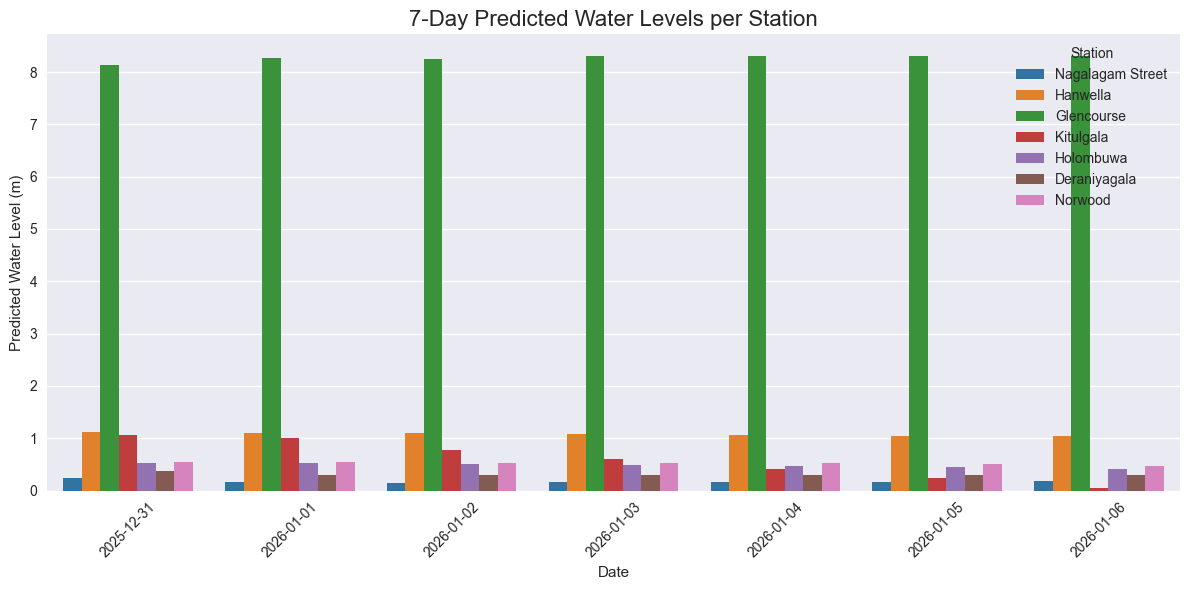

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

# x-axis: Dates
sns.barplot(
    data=forecast_df,
    x='Date',
    y='Predicted Level (m)',
    hue='Station',
    palette='tab10'
)

plt.title("7-Day Predicted Water Levels per Station", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Predicted Water Level (m)")
plt.xticks(rotation=45)
plt.legend(title="Station")
plt.tight_layout()
plt.show()
